In [1]:
# Import all the handy libraries.
import numpy as np
import pandas as pd
import os
#import matplotlib.pyplot as plt
#import seaborn as sns
import plotly.graph_objects as go
#from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import pickle

In [88]:
class MSHM:
    def __init__(self, path):
        # Set path
        self.path = path
        
        # Creat self.__dfs
        self.__dfs = self.__prep_dfs()
        self.__dfs_ori = self.__dfs
        
        # Creat __index
        self.__index = self.index()
        self.__index_ori = self.__index
        
        # Creat __range
        self.__range = self.mw_range()
        self.__range_ori = self.__range
        
        # recursion guard
        self.__recursion = False
        
    # Read index from dfs
    def index(self):
        index = self.__dfs['array'].index.to_list()
        return index
    
    # Read range from dfs
    def mw_range(self):
        r = [self.__dfs['array'].columns[0],self.__dfs['array'].columns[-1]]
        return  r
    
    # Read index from dfs
    def index_ori(self):
        return self.__index_ori
    
    # Read range from dfs
    def mw_range_ori(self):
        return self.__range_ori

    # This is a function that get all the folder names in the directory.
    def __get_folders(self):
        folders = []
        path = self.path
        for item in os.listdir(path):
            if os.path.isdir(os.path.join(path, item)):
                folders.append(item)
        return folders
    
    # This is a function that generate the array of intensity across mass for all deconvoluted samples. 
    def __prep_array(self):
        # Obtain the folder names, aka "sample names", from the directory.
        folders = self.__get_folders()
        # Create a empty dataframe to store data
        array = pd.DataFrame()
        for n in range(len(folders)):
            # Create an index.
            index = [folders[n][:-19]]
            # Read the data from _mass.txt file.
            data = pd.read_table(self.path+'/'+folders[n]+'/'+folders[n][:-12]+'_mass.txt',delim_whitespace=True, header=None, index_col=0).transpose().set_axis(index)
            # Concat to the array.
            array =pd.concat([array,data])
            #### End of the loop.
        array = array.divide(array.max(axis=1), axis = 0)
        return array
    
    # This is a function that generate the array of intensity and molecular weight of all peaks.
    def __prep_peaks(self):
        # Obtain the folder names, aka "sample names", from the directory.
        folders = self.__get_folders()
        # Create a empty dataframe to store data
        array = pd.DataFrame()
        n_array = pd.DataFrame()
        n_peak_info = pd.DataFrame()
        # A loop to obtain the peak data from each folder.
        for n in range(len(folders)):
            # Create a hierarchical index.
            tuples=[(folders[n][:-19], "Mass"), (folders[n][:-19], "Intensity")]
            index = pd.MultiIndex.from_tuples(tuples, names=["Sample", "Value"])
            # Read the "*_peaks.dat" file, which containing the "Mass" and "Intensity" data.
            peak_info = pd.read_table(self.path+'/'+folders[n]+'/'+folders[n][:-12]+'_peaks.dat', header=None, delim_whitespace=True).transpose().set_axis(index)
            # Add the above dataframe to the array.
            array =pd.concat([array,peak_info])
            #### End of the loop.
        # return result as array
        return array
    
    # Assemble array and peaks into a dictionary.
    def __prep_dfs(self):
        array = self.__prep_array()
        array.columns = array.columns.astype(int)
        peaks = self.__prep_peaks()
        self.__dfs = {"array":array,"peaks":peaks}
        return self.__dfs
    
    # This is a function to filter and sort samples. 
    def set_index(self,order = None):
        # if called by set_mw_range(), use costume order as order.
        if order is None:
            order = self.__index
            # and will use __dfs as template
            array= self.__dfs["array"].loc[order,:]
            peaks= self.__dfs["peaks"].loc[order,:]            
        # otherwise, use inputed order
        else:
            order = order
            # use original dfs as the template
            array= self.__dfs_ori["array"].loc[order,:]
            peaks= self.__dfs_ori["peaks"].loc[order,:]
        # update the order
        self.__index = order
        # update the dfs
        self.__dfs = {"array":array,"peaks":peaks}
        # set range.
        if not self.__recursion:
            self.__recursion = True
            self.set_mw_range()
            self.__recursion = False
            
    def set_mw_range(self,r = None):
        # if called by set_index(), use costume range as range.
        if r is None:
            r = self.__range
            array = self.__dfs["array"]
            peaks = self.__dfs["peaks"]
        # otherwise, use inputed order
        else:
            r = r
            # sign the original data to array and peaks
            array = self.__dfs_ori["array"]
            peaks = self.__dfs_ori["peaks"]

        # check if r leads between minimun and maximun values.
        if r[0] < self.__dfs_ori["array"].columns[0]:
            left = self.__dfs_ori["array"].columns[0]
        else:
            left = r[0]
        if r[0] > self.__dfs_ori["array"].columns[-1]:
            right = self.__dfs_ori["array"].columns[-1]
        else:
            right = r[1]
        # Set range for 'array'
        array_columns=array.columns[(array.columns >= left) & (array.columns <= right)]
        array = array[array_columns]
        # Set range for 'peaks'
        peaks_temp = pd.DataFrame()
        peaks_temp_slice = pd.DataFrame()
        for i in range(0,len(peaks.index),2):
            peaks_temp_slice = peaks.iloc[i:i+2,:]
            mask = (peaks_temp_slice.iloc[0,:] <= right) & (peaks_temp_slice.iloc[0,:] >= left)
            peaks_temp_slice = peaks_temp_slice.loc[:,mask]
            peaks_temp_slice.columns = range(peaks_temp_slice.shape[1])
            peaks_temp =pd.concat([peaks_temp,peaks_temp_slice])
        peaks = peaks_temp
        # update range
        self.__range = r
        # update dfs
        self.__dfs = {"array":array,"peaks":peaks}
        # set index
        if not self.__recursion:
            self.__recursion = True
            self.set_index()
            self.__recursion = False

    def save_to_file(self, file_path):
        with open(file_path, 'wb') as output_file:
            pickle.dump(self, output_file)
    def load_from_file(file_path):
        with open(file_path, 'rb') as input_file:
            return pickle.load(input_file)
        
    # This is a function to plot the figure in plotly. 
    def pfunction(self, title="", color="electric_r"):
        df = self.__dfs['array']
        pk = self.__dfs['peaks']
        fig = px.imshow(df, color_continuous_scale=color)
        fig.add_shape(
            type="rect",
            x0=df.columns[0]-0.5,  # Start x-coordinate (adjusted to align with heatmap)
            y0=0-0.5,  # Start y-coordinate
            x1=df.columns[-1]+0.5,  # End x-coordinate
            y1=df.shape[0]-0.5,  # End y-coordinate
            line=dict(
                color="black",
                width=2
            ),
            fillcolor="rgba(0,0,0,0)"  # Transparent fill
        )
        for i in range(len(df.index)-1):
            fig.add_shape(
                type="line",
                x0=df.columns[0]-0.5,  # Start x-coordinate (adjusted to align with heatmap)
                y0=i+0.5,  # Start y-coordinate
                x1=df.columns[-1]+0.5,  # End x-coordinate
                y1=i+0.5,  # End y-coordinate
                line=dict(
                    color="black",
                    width=1
                )
            )
        
        for i in range(len(df.index)):
            sample_name = df.index[i]
            peak = pk.loc[sample_name,:].dropna(axis = 1)
            for j in range(len(peak.columns)):
                mass = peak.iloc[0,j].astype(int)
                intensity = str(peak.iloc[1,j].round(1))+"%"
                fig.add_annotation(
                        x=mass,  # x-coordinate where the annotation should be placed
                        y=i-0.2,
                        text= f"<span style='letter-spacing: -1px;'><b>{mass:}</b></span>",
                        showarrow=False,
                        textangle=25,
                        font=dict(
                        color="#4A90E2",
                        size=9)
                    )
                fig.add_annotation(
                        x=mass,  # x-coordinate where the annotation should be placed
                        y=i+0.2,
                        text=f"<span style='letter-spacing: -1px;'><b>{intensity}</b></span>",
                        showarrow=False,
                        textangle=25,
                        font=dict(
                        color="#ff66cc",
                        size=9)
                    )      
        fig.update_layout(
            title={
                'text': f'<b>{title}</b>', # Bold Text
                'xanchor': 'center',  # Anchor the title at its center
                'yanchor': 'middle',  # Anchor the title at its middle
                'y':(len(df.index)*50+100)/(len(df.index)*50+150),  # Put the center of the title 50 pixel away from the figure top border
                'x':0.5,  # Center the title
                'font': {
                    'size':24,
                    'color':"black"
                }
            },

            xaxis=dict(
                showline=True,  # Show the x-axis line
                linewidth=3,
                linecolor='black',
                mirror=True,     # Mirror the line to the top
                title=dict(
                    text=f'<b>Molecular Weight (Da)</b>',
                    font=dict(size=16)
                )
            ),
            yaxis=dict(
                showline=True,  # Show the y-axis line
                linewidth=3,
                linecolor='black',
                mirror=True,     # Mirror the line to the right
                title=dict(
                    text=f'<b>Samples</b>',
                    font=dict(size=16)
                )
            ),
            width= 1200,
            height= len(df.index)*50+150,
            margin=dict(
                l=200,
                r=100,
                b=50,
                t=100
            )
        )
        return fig

In [96]:
ex0125 = MSHM("./WORKING/2024-01-25 screening test/")

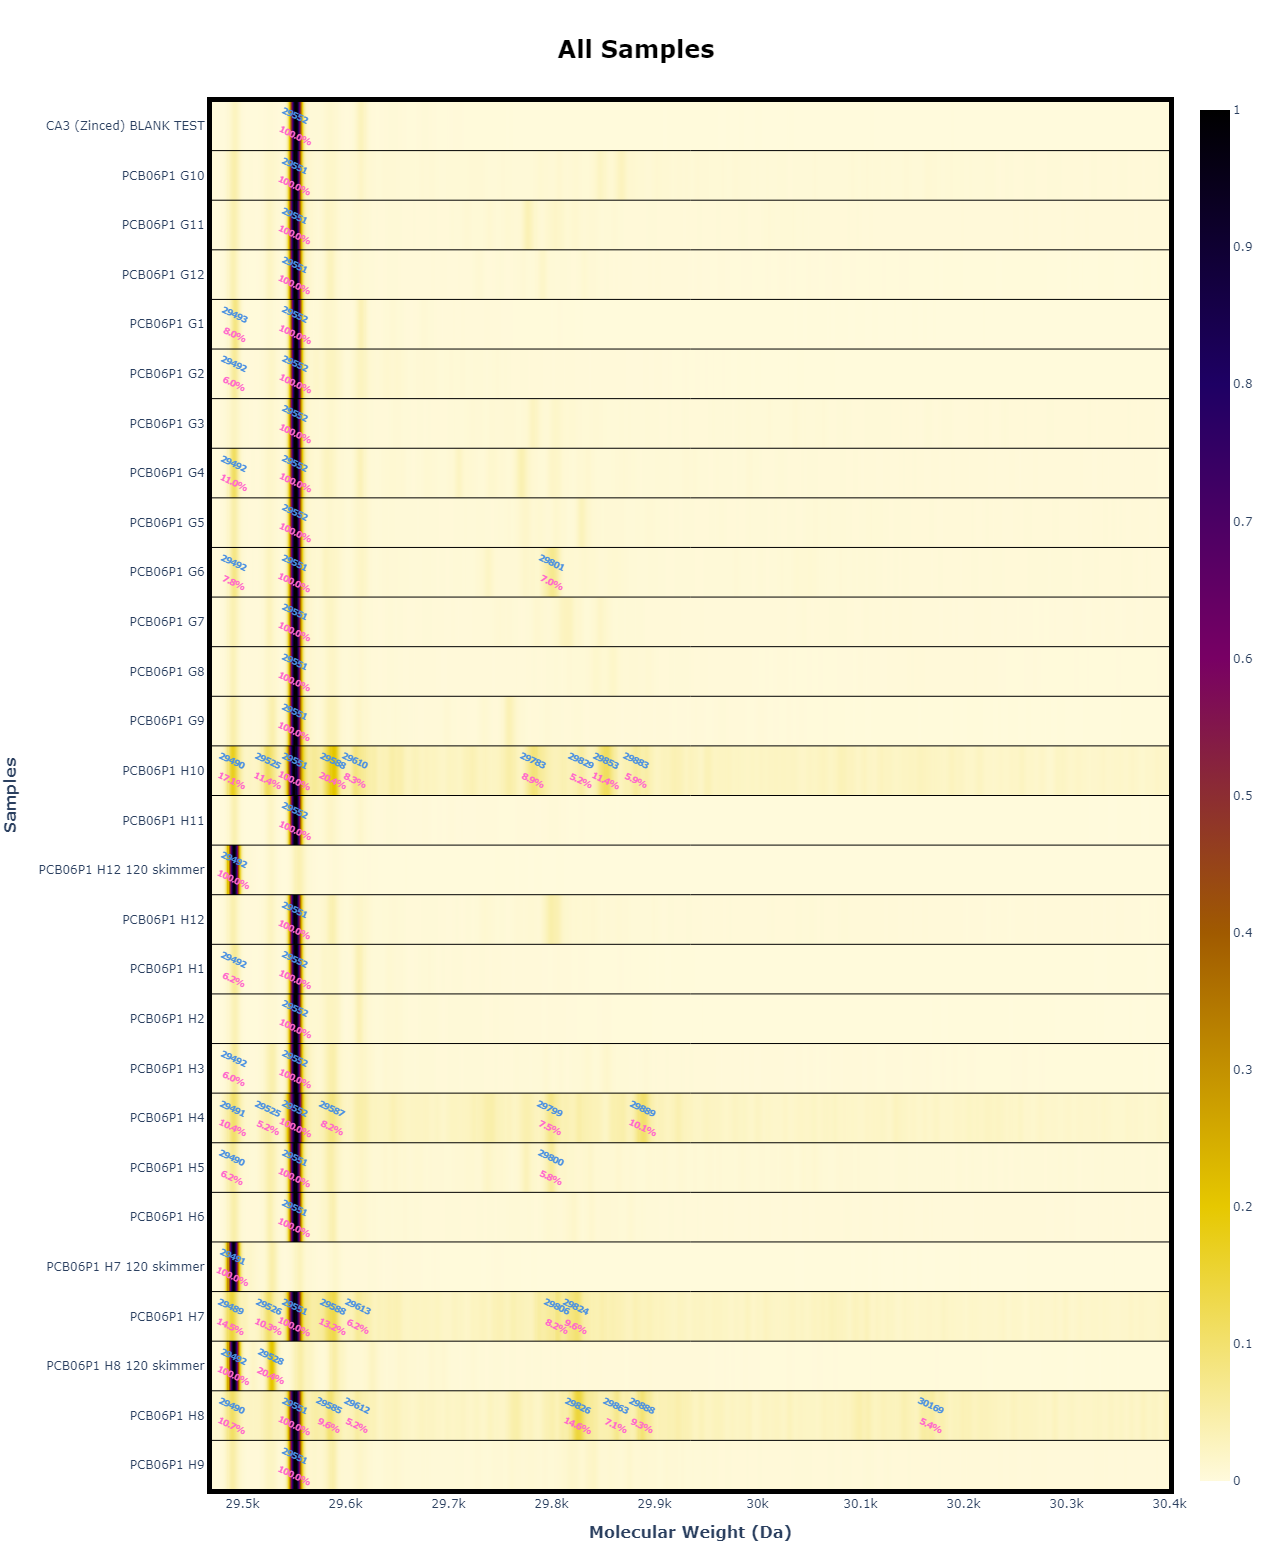

In [108]:
ex0125.set_index(ex0125.index_ori())
ex0125.set_mw_range([29470,30400])
ex0125.pfunction('All Samples')

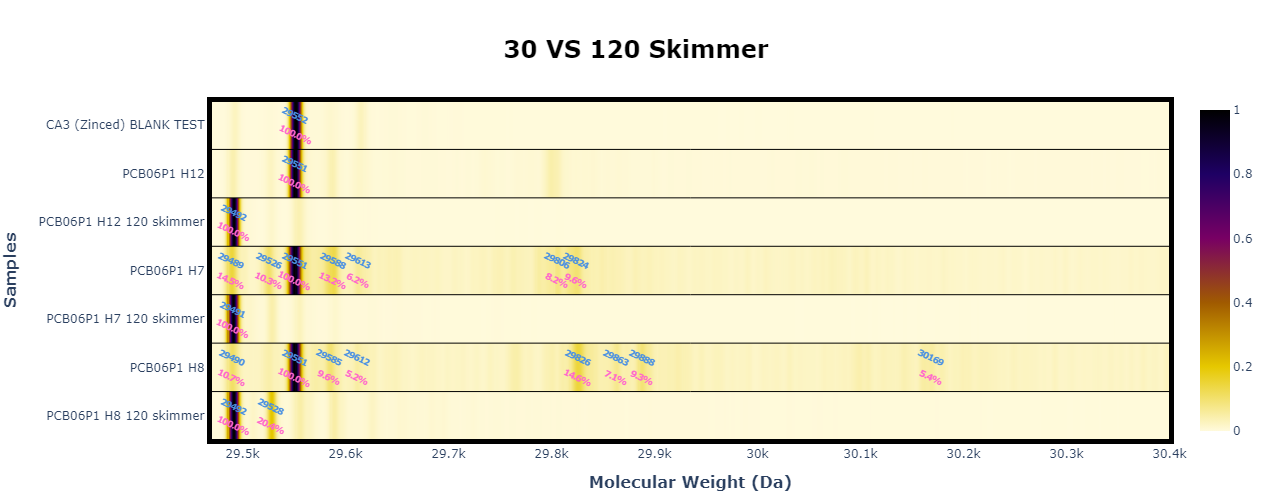

In [103]:
ex0125.set_index(['CA3 (Zinced) BLANK TEST',
    'PCB06P1 H12',
    'PCB06P1 H12 120 skimmer',
    'PCB06P1 H7',
    'PCB06P1 H7 120 skimmer',
    'PCB06P1 H8',
    'PCB06P1 H8 120 skimmer'])
ex0125.set_mw_range([29470,30400])
ex0125.pfunction(title='30 VS 120 Skimmer')